<h3>In this notebook, I want to share with you one of my favorite Python libraries - sktime. As the package name suggests, sktime is basically scikit-learn with some nice time series components. This will be inspired by their walkthrough linked below.</h3>

https://www.sktime.org/en/stable/examples/01_forecasting.html

## <center>TPS September 2022</center>

<ol>
    <li>Install Sktime</li>
    <li>Load Libraries</li>
    <li>Load Data</li>
    <li>Exploratory Data Analysis</li>
    <li>Starting Simple: One Product, Naive Forecast</li>
    <li>Repeating the Process for All 48 Product Combinations</li>
    <li>Submission</li>
</ol>

## Install Sktime

In [1]:
!pip install sktime --root-user-action=ignore
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.5 MB/s eta 0:00:00


## Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn as sklearn
import sktime

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.base import ForecastingHorizon
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sktime.transformations.series.detrend import Deseasonalizer, ConditionalDeseasonalizer, Detrender
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.trend import PolynomialTrendForecaster
from sklearn.ensemble import GradientBoostingRegressor
from sktime.utils.plotting import plot_series

from sktime.forecasting.compose import ForecastingPipeline
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from statsmodels.tsa.deterministic import CalendarFourier

from lightgbm import LGBMRegressor
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter

In [3]:
print("Loaded Libraries")

Loaded Libraries


## Load Data

In [4]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

## Exploratory Data Analysis

In [5]:
train.head()

row_id        date  country       store                           product  \
0       0  2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1  2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2  2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3  2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4  2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

In [6]:
test.head()

row_id        date  country       store                           product
0   70128  2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129  2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130  2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131  2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132  2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [7]:
test.shape

(17520, 5)

In [8]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [9]:
train.set_index('row_id', inplace=True)
test.set_index('row_id', inplace=True)

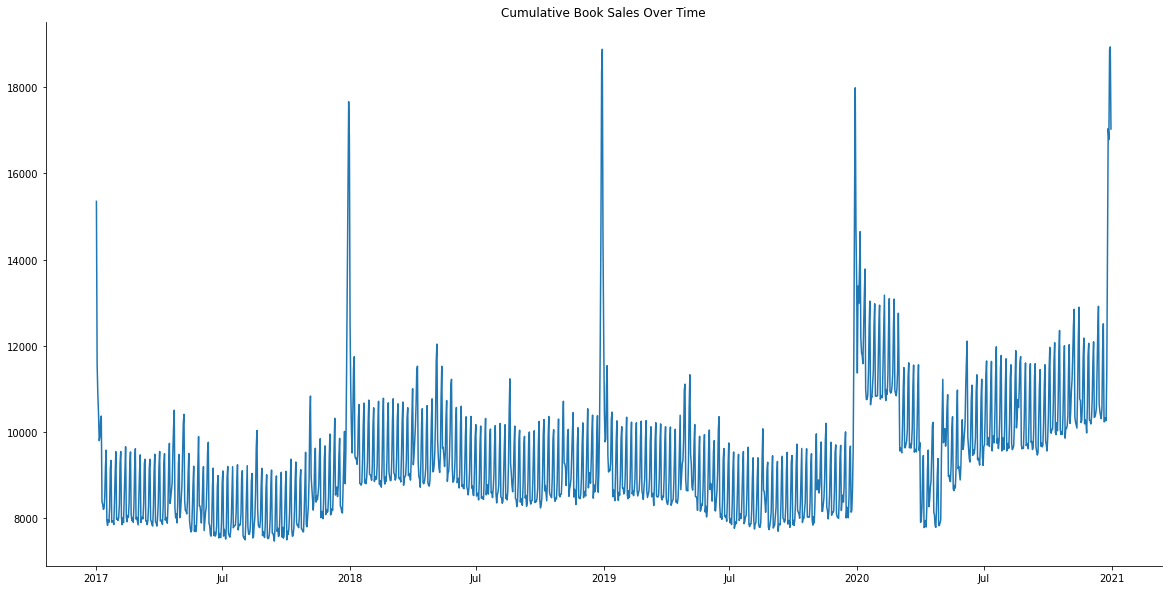

In [10]:
f, ax = plt.subplots(figsize=(20, 10))

ax.plot(train.groupby(['date']).sum())
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Book Sales Over Time')
sns.despine()
plt.show()

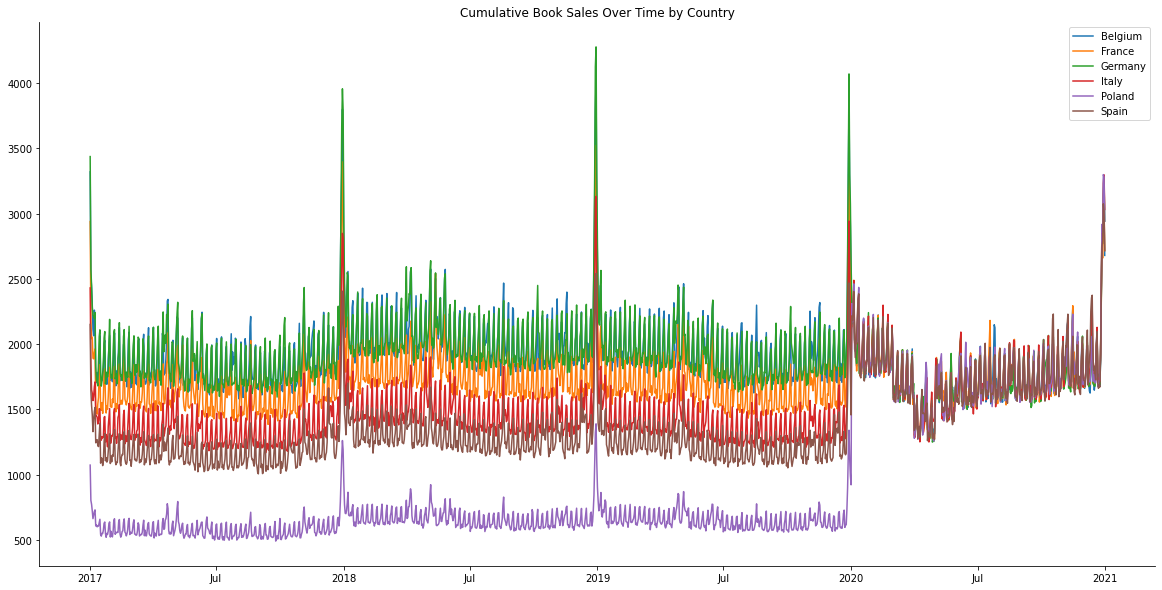

In [11]:
# Sales by date, country over time

f, ax = plt.subplots(figsize=(20, 10))
bycountry = train.groupby(['date', 'country']).sum().unstack()
labels = bycountry.columns
ax.plot(bycountry)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Book Sales Over Time by Country')
sns.despine()
plt.legend(bycountry['num_sold'].columns)
plt.show()

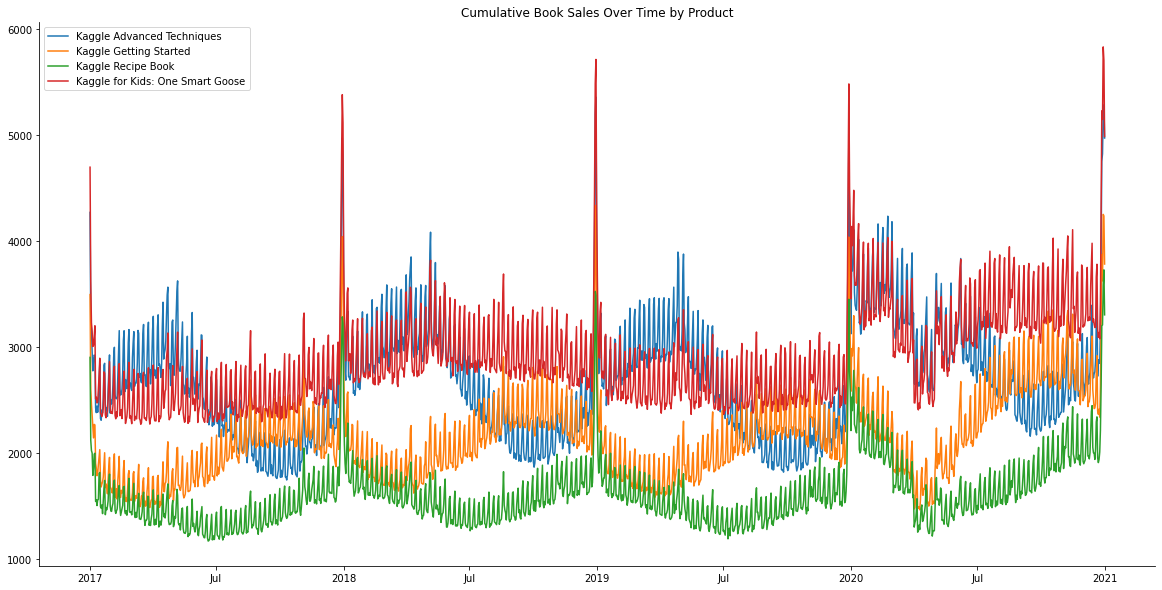

In [12]:
# Sales by date, store over time

f, ax = plt.subplots(figsize=(20, 10))
bycountry = train.groupby(['date', 'product']).sum().unstack()
labels = bycountry.columns
ax.plot(bycountry)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Book Sales Over Time by Product')
sns.despine()
plt.legend(bycountry['num_sold'].columns)
plt.show()

## Starting Simple: One Product, Naive Forecaster

Using sample from https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.base.ForecastingHorizon.html

In [13]:
sample_timeseries = train[::48]
sample_test = test[::48]

In [14]:
X_train = pd.DataFrame()
X_train.index = pd.DatetimeIndex(sample_timeseries['date'], freq='D')
X_test = pd.DataFrame()
X_test.index = pd.DatetimeIndex(sample_test['date'], freq='D')

# Date features
X_train['dayofweek'] = sample_timeseries['date'].dt.dayofweek.values
X_test['dayofweek'] = sample_test['date'].dt.dayofweek.values

X_train['dayofmonth'] = sample_timeseries['date'].dt.day.values
X_test['dayofmonth'] = sample_test['date'].dt.day.values

X_train['dayofyear'] = sample_timeseries['date'].dt.dayofyear.values
X_test['dayofyear'] = sample_test['date'].dt.dayofyear.values

X_train['month'] = sample_timeseries['date'].dt.month.values
X_test['month'] = sample_test['date'].dt.month.values

X_train['year'] = sample_timeseries['date'].dt.year.values - sample_timeseries['date'].dt.year.min()
X_test['year'] = sample_test['date'].dt.year.values - sample_timeseries['date'].dt.year.min()

# Fourier Features
cal_fourier_gen = CalendarFourier("Y", 1)
X_train[['Sin', 'Cos']] = cal_fourier_gen.in_sample(X_train.index)
X_test[['Sin', 'Cos']] = cal_fourier_gen.in_sample(X_test.index)

# Pandemic
X_train['Pandemic'] = (X_train.index.year >= 2020).astype(int)
X_test['Pandemic'] = (X_test.index.year >= 2020).astype(int)

0.0637658602517903


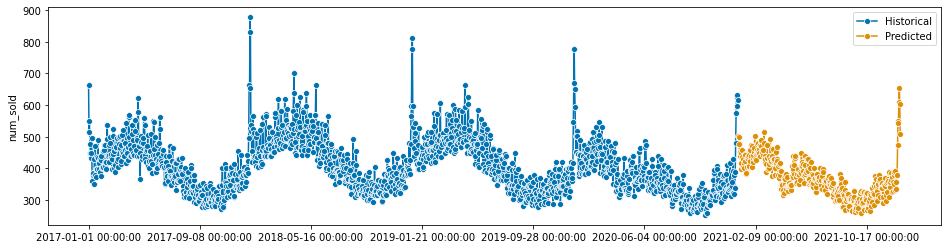

In [15]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
y_train = sample_timeseries['num_sold']
y_train.index = pd.DatetimeIndex(sample_timeseries['date'], freq='D')

predicted_dates = pd.DatetimeIndex(sample_test['date'], freq='D')
gradient_booster = make_reduction(LGBMRegressor(objective ='regression',
                                                metric = 'mae',
                                                random_state = 42,
                                                max_depth=5,
                                                num_leaves=20,
                                                learning_rate=.2), window_length=5)

forecaster = TransformedTargetForecaster(steps=[
    ("Deseasonalize_Year", Deseasonalizer(sp=365, model='multiplicative')),
    ("Deseasonalize_Month", Deseasonalizer(sp=30, model='multiplicative')),
    ("Deseasonalize_Week", Deseasonalizer(sp=7, model='multiplicative')),
    ("Booster", gradient_booster),
])

pipe = ForecastingPipeline(steps=[("Scaler", TabularToSeriesAdaptor(StandardScaler())), ("Forecaster", forecaster)])

# Forecast product sales for the next year
fh=ForecastingHorizon(predicted_dates, is_relative=False)
pipe.fit(y=y_train, X=X_train)
y_pred = pipe.predict(fh=fh, X=X_test)
print(pipe.score(y_train[-365:], X=X_train[-365:]))

plot_series(y_train, y_pred, labels=['Historical', 'Predicted'])
plt.show()


## Repeating the Process for All 48 Product Combinations

Predicting product ['Belgium' 'KaggleMart' 'Kaggle Advanced Techniques']
0.0637658602517903


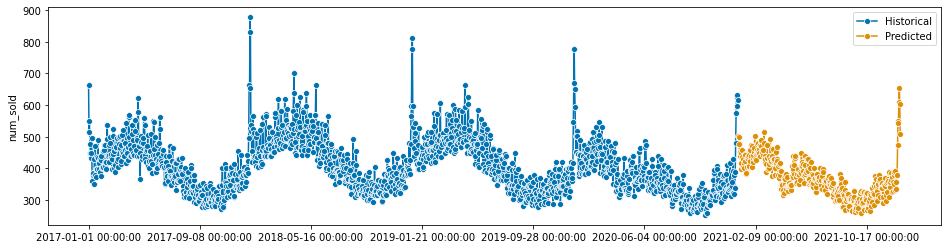

Predicting product ['Belgium' 'KaggleMart' 'Kaggle Getting Started']
0.06668129137719607


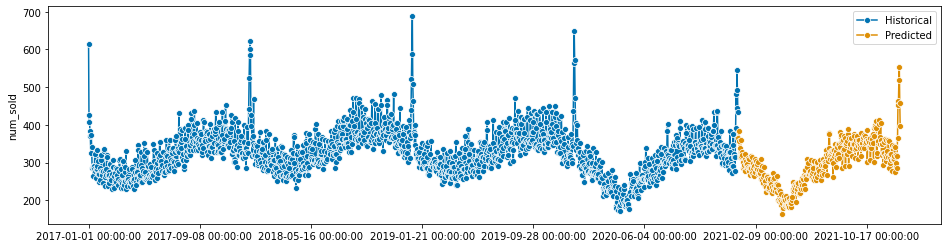

Predicting product ['Belgium' 'KaggleMart' 'Kaggle Recipe Book']
0.06784091832887056


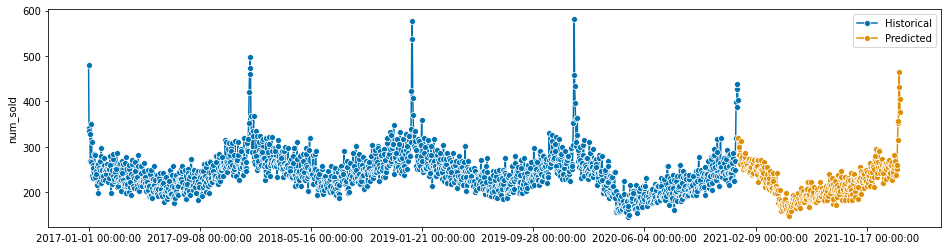

Predicting product ['Belgium' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.07781418648855642


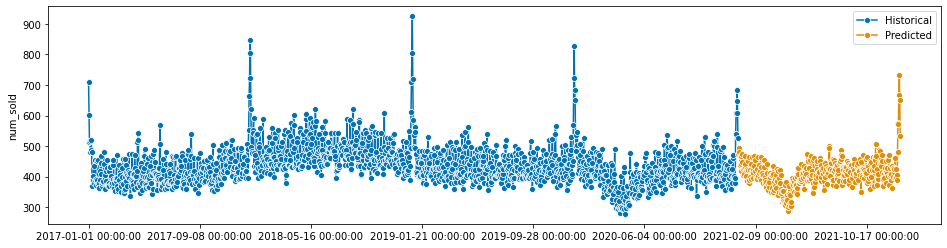

Predicting product ['Belgium' 'KaggleRama' 'Kaggle Advanced Techniques']
0.06934952376982295


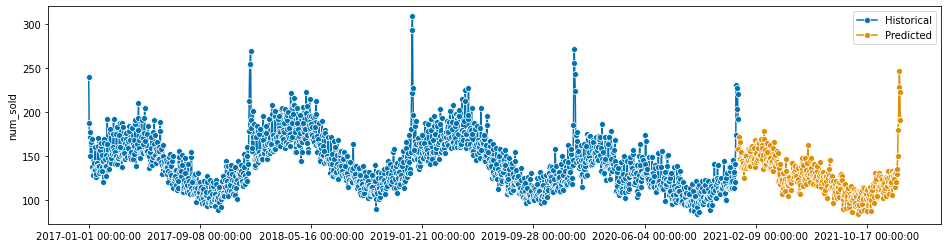

Predicting product ['Belgium' 'KaggleRama' 'Kaggle Getting Started']
0.06569819121330799


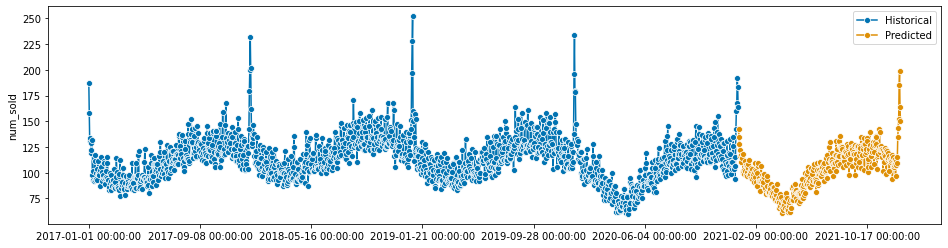

Predicting product ['Belgium' 'KaggleRama' 'Kaggle Recipe Book']
0.06621404460203449


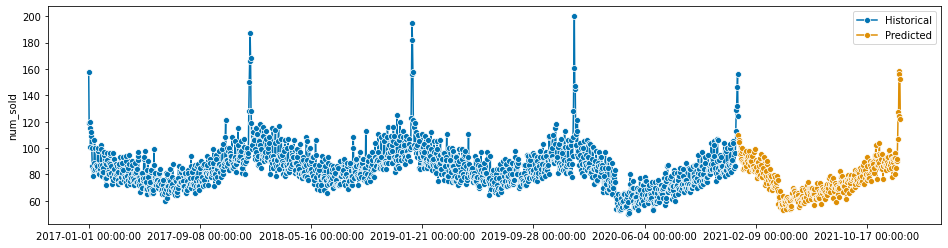

Predicting product ['Belgium' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.07200332706102819


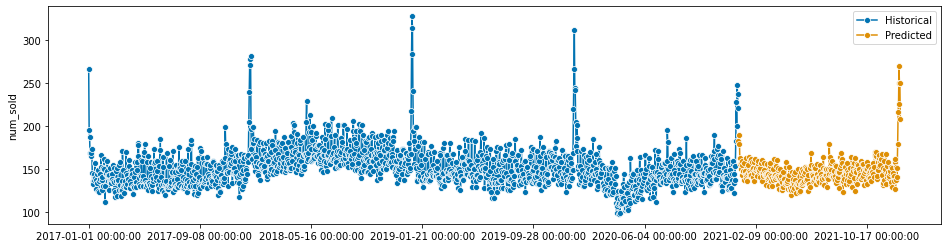

Predicting product ['France' 'KaggleMart' 'Kaggle Advanced Techniques']
0.06726001077629143


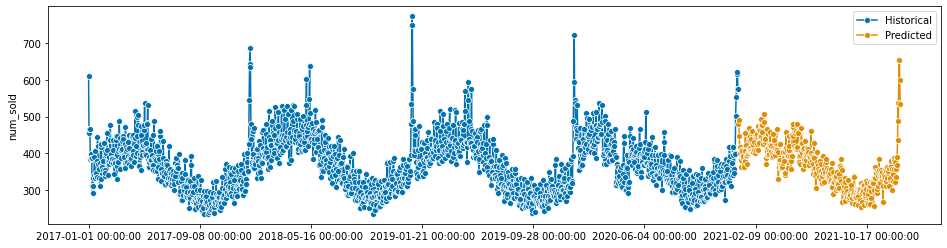

Predicting product ['France' 'KaggleMart' 'Kaggle Getting Started']
0.08886737956335734


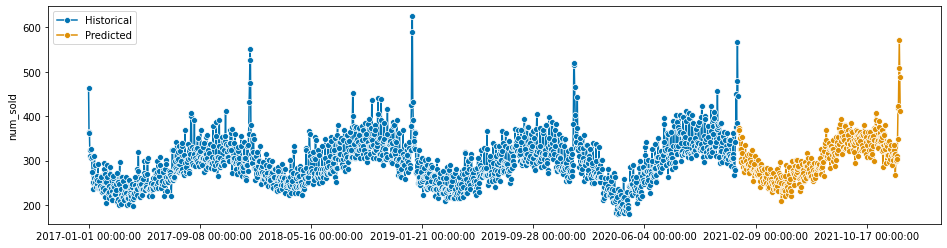

Predicting product ['France' 'KaggleMart' 'Kaggle Recipe Book']
0.08200409565750946


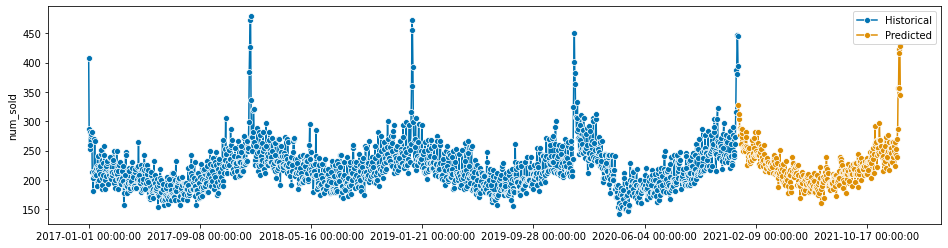

Predicting product ['France' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.09132311276512813


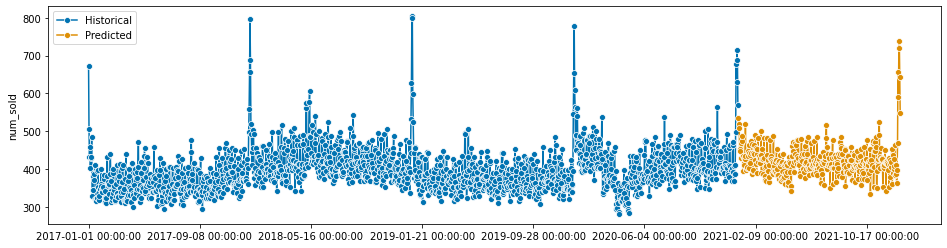

Predicting product ['France' 'KaggleRama' 'Kaggle Advanced Techniques']
0.08409264742764859


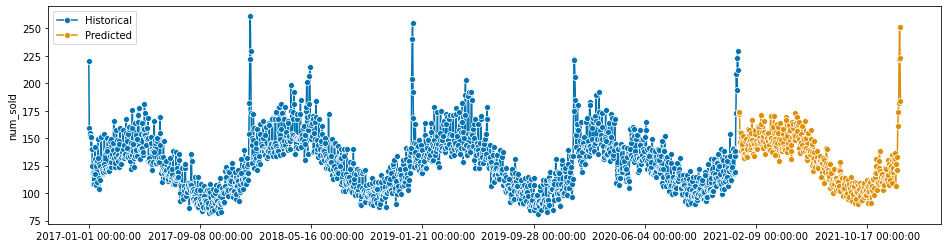

Predicting product ['France' 'KaggleRama' 'Kaggle Getting Started']
0.09008294087405516


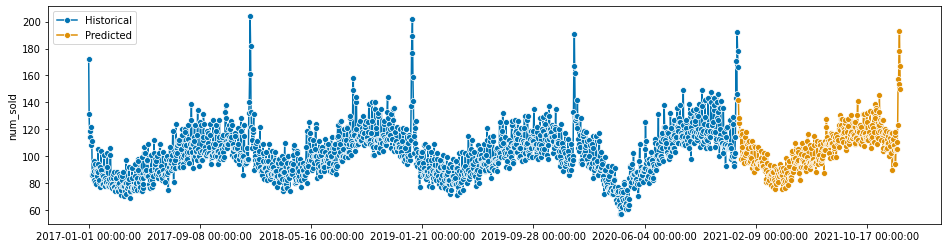

Predicting product ['France' 'KaggleRama' 'Kaggle Recipe Book']
0.0844851541671313


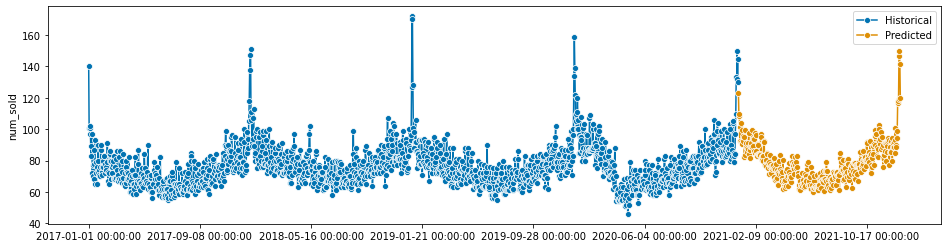

Predicting product ['France' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.06976093751691279


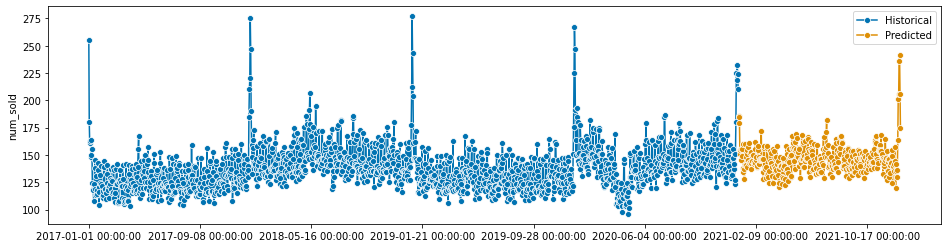

Predicting product ['Germany' 'KaggleMart' 'Kaggle Advanced Techniques']
0.06865467394136086


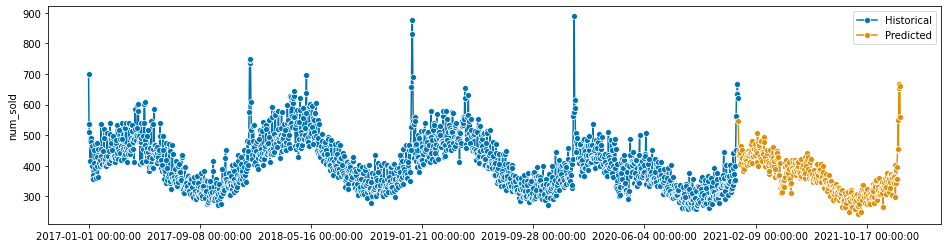

Predicting product ['Germany' 'KaggleMart' 'Kaggle Getting Started']
0.06450468456890714


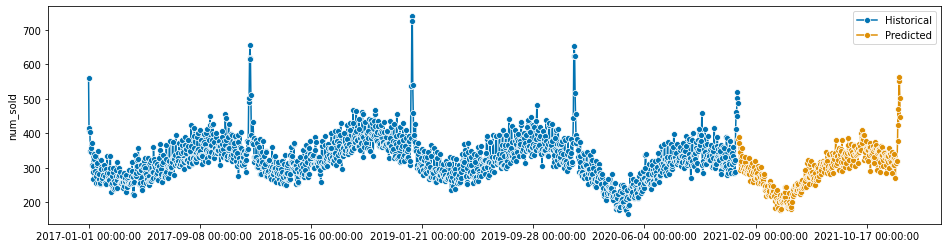

Predicting product ['Germany' 'KaggleMart' 'Kaggle Recipe Book']
0.06955317011003619


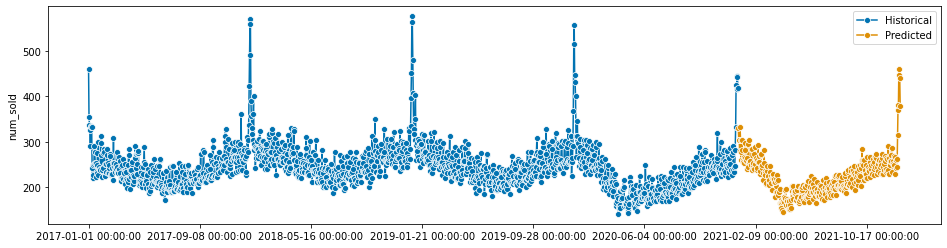

Predicting product ['Germany' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.07250216731604878


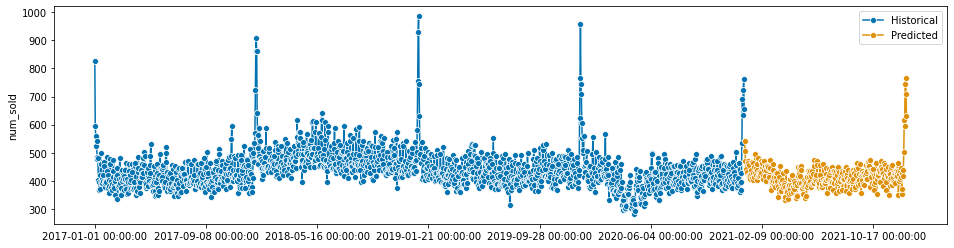

Predicting product ['Germany' 'KaggleRama' 'Kaggle Advanced Techniques']
0.06691123469931984


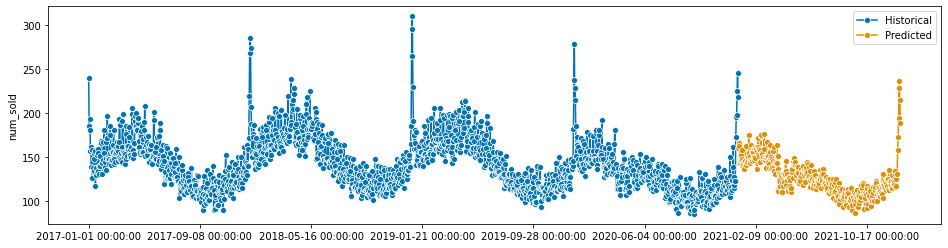

Predicting product ['Germany' 'KaggleRama' 'Kaggle Getting Started']
0.06512187245960599


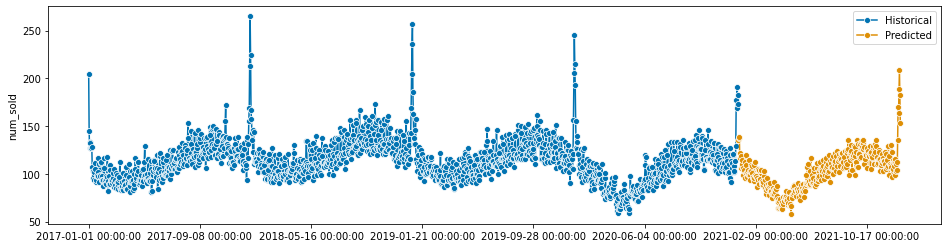

Predicting product ['Germany' 'KaggleRama' 'Kaggle Recipe Book']
0.06727540182978206


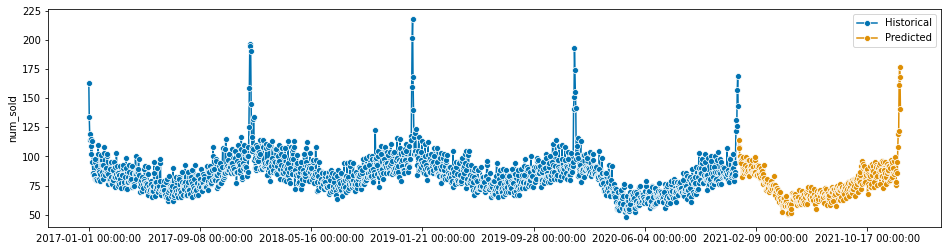

Predicting product ['Germany' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.07014300123490773


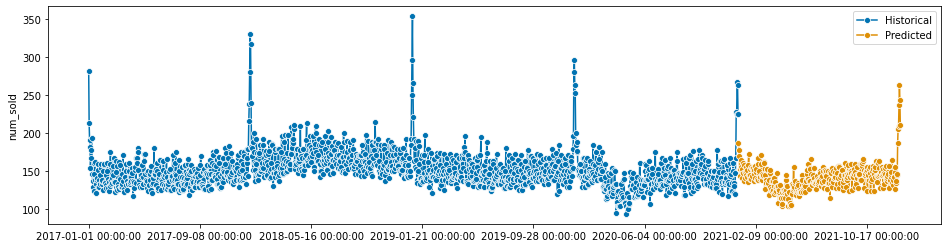

Predicting product ['Italy' 'KaggleMart' 'Kaggle Advanced Techniques']
0.06162855690932242


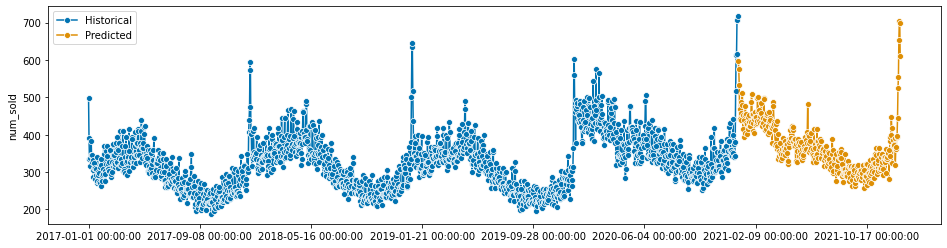

Predicting product ['Italy' 'KaggleMart' 'Kaggle Getting Started']
0.065471709873219


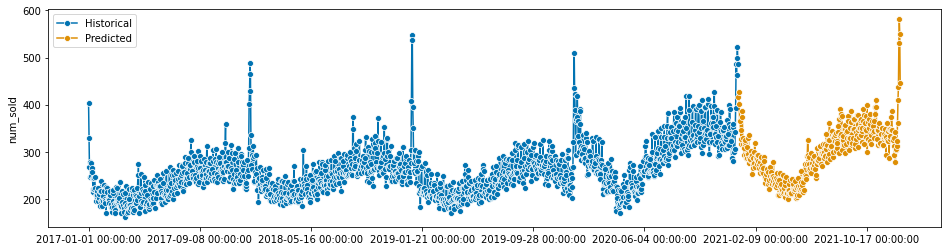

Predicting product ['Italy' 'KaggleMart' 'Kaggle Recipe Book']
0.06598815869043095


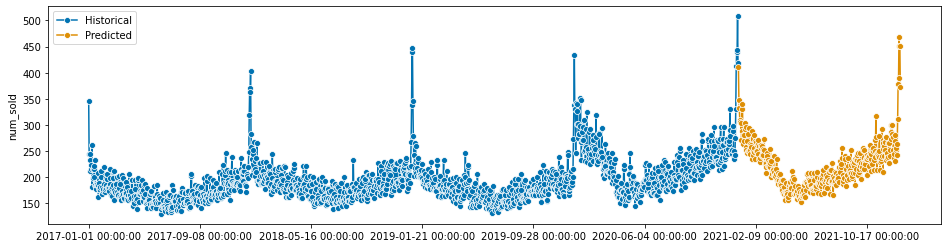

Predicting product ['Italy' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.06546919310576953


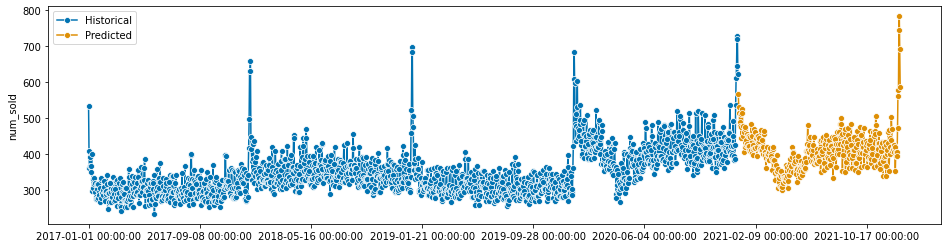

Predicting product ['Italy' 'KaggleRama' 'Kaggle Advanced Techniques']
0.0681003834144692


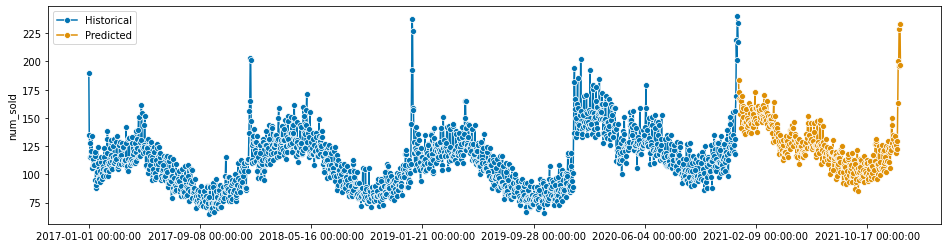

Predicting product ['Italy' 'KaggleRama' 'Kaggle Getting Started']
0.06257716960090133


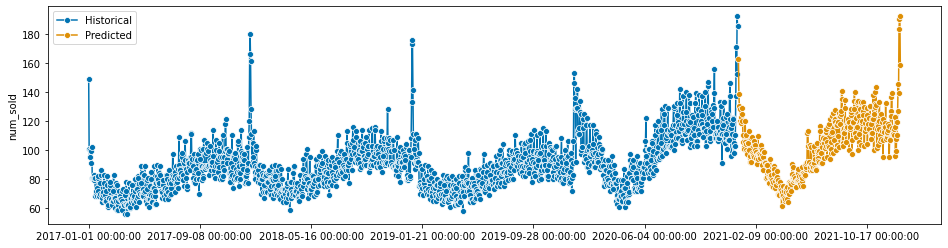

Predicting product ['Italy' 'KaggleRama' 'Kaggle Recipe Book']
0.07456190096403094


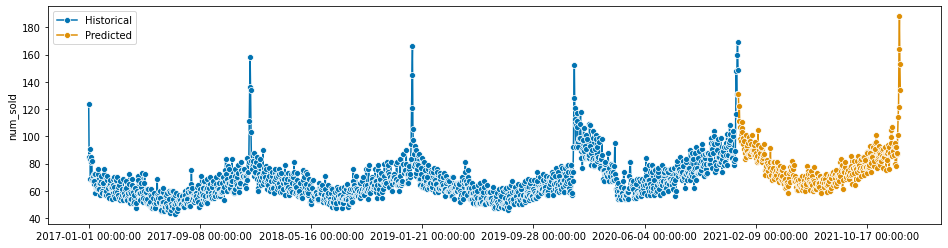

Predicting product ['Italy' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.0662761539839828


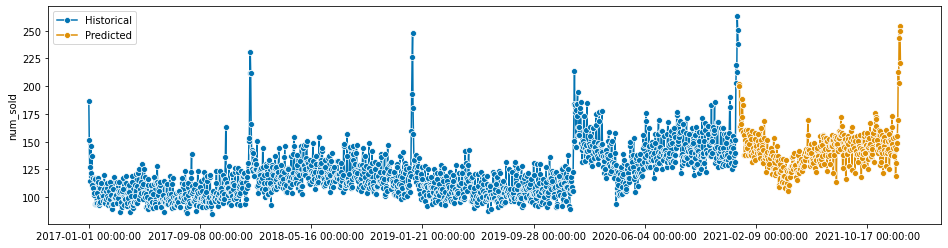

Predicting product ['Poland' 'KaggleMart' 'Kaggle Advanced Techniques']
0.06307906148715009


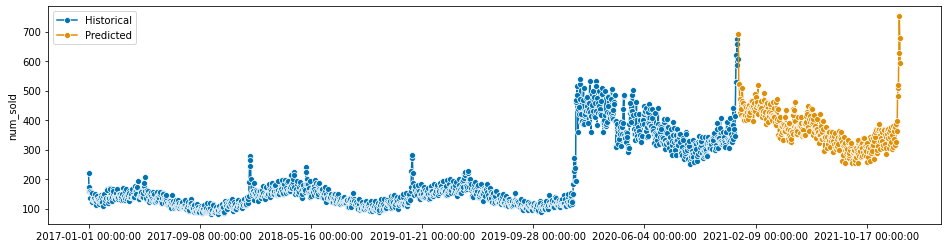

Predicting product ['Poland' 'KaggleMart' 'Kaggle Getting Started']
0.06751833047851002


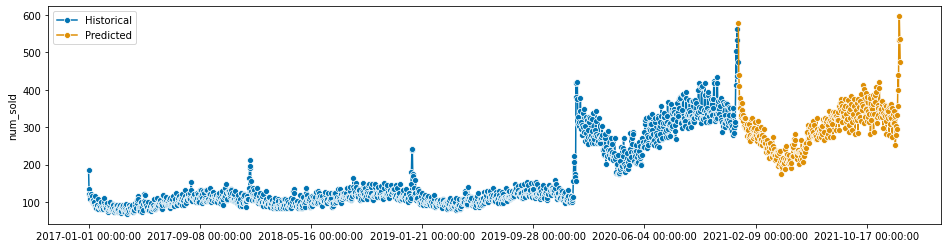

Predicting product ['Poland' 'KaggleMart' 'Kaggle Recipe Book']
0.0621966287998501


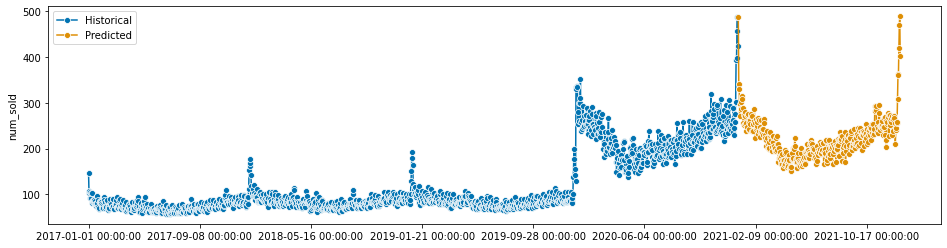

Predicting product ['Poland' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.06752433627747938


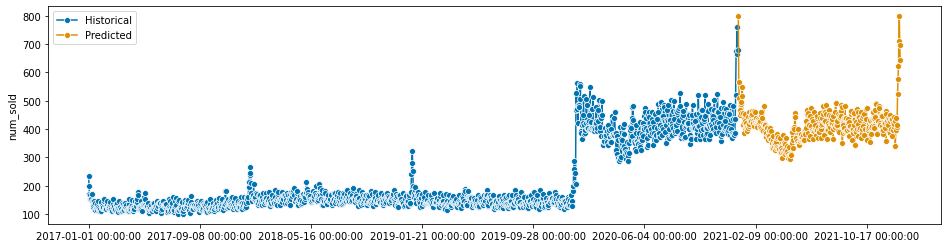

Predicting product ['Poland' 'KaggleRama' 'Kaggle Advanced Techniques']
0.06719494866645531


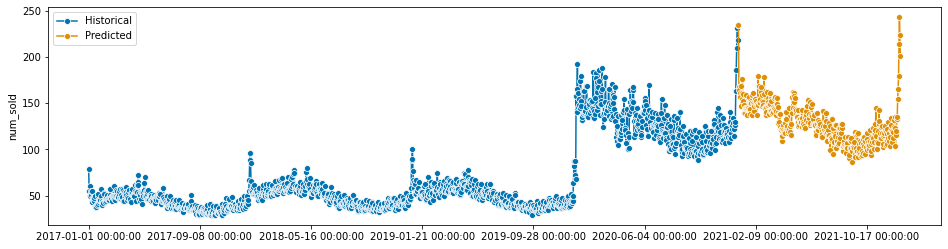

Predicting product ['Poland' 'KaggleRama' 'Kaggle Getting Started']
0.06622668538479201


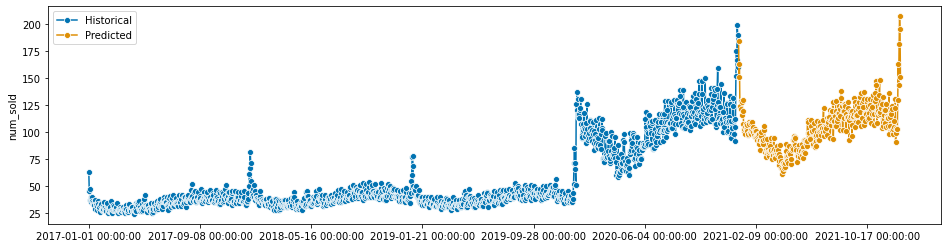

Predicting product ['Poland' 'KaggleRama' 'Kaggle Recipe Book']
0.06525746571266018


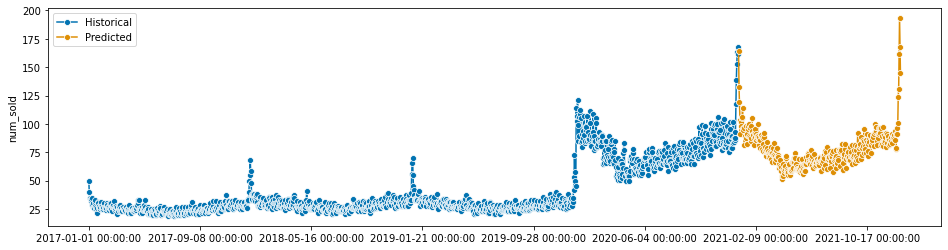

Predicting product ['Poland' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.06504982285585223


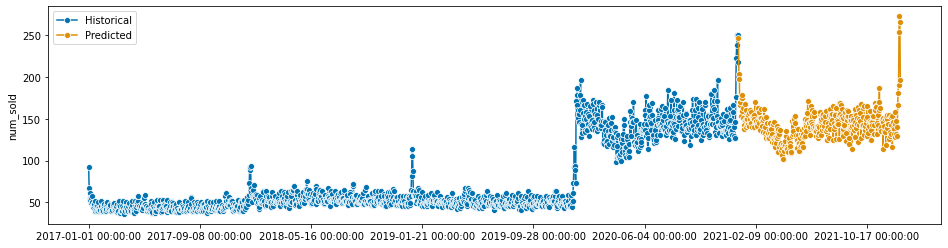

Predicting product ['Spain' 'KaggleMart' 'Kaggle Advanced Techniques']
0.06177198653198121


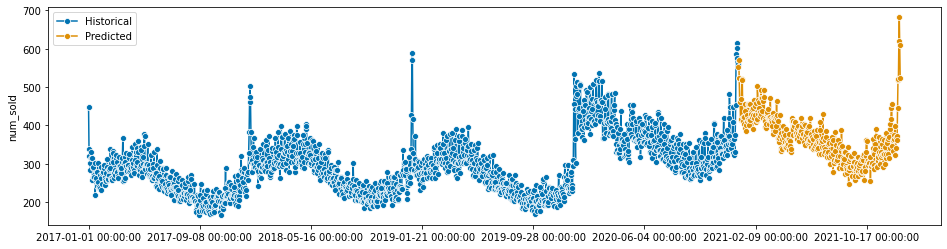

Predicting product ['Spain' 'KaggleMart' 'Kaggle Getting Started']
0.06373550463944308


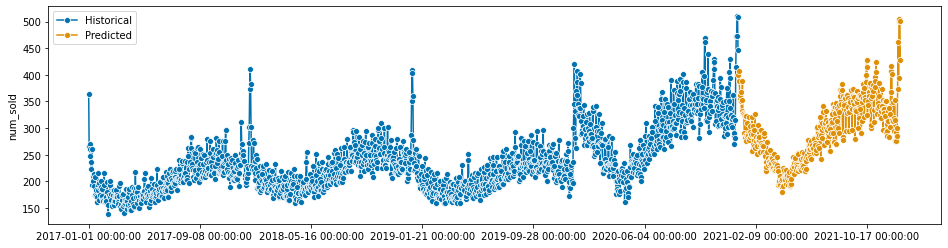

Predicting product ['Spain' 'KaggleMart' 'Kaggle Recipe Book']
0.07170614463808771


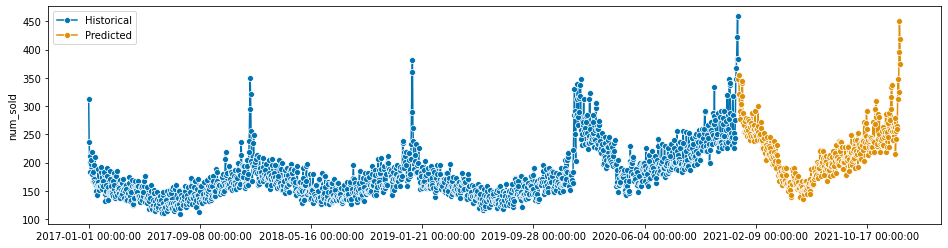

Predicting product ['Spain' 'KaggleMart' 'Kaggle for Kids: One Smart Goose']
0.06805711500071496


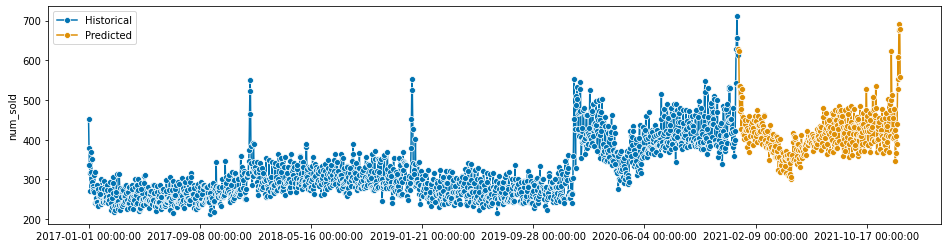

Predicting product ['Spain' 'KaggleRama' 'Kaggle Advanced Techniques']
0.06469418132129146


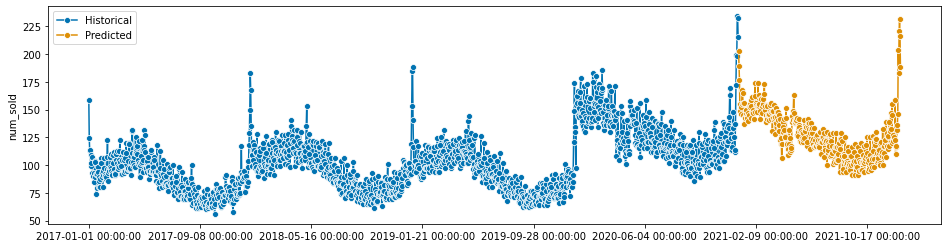

Predicting product ['Spain' 'KaggleRama' 'Kaggle Getting Started']
0.06284728312101028


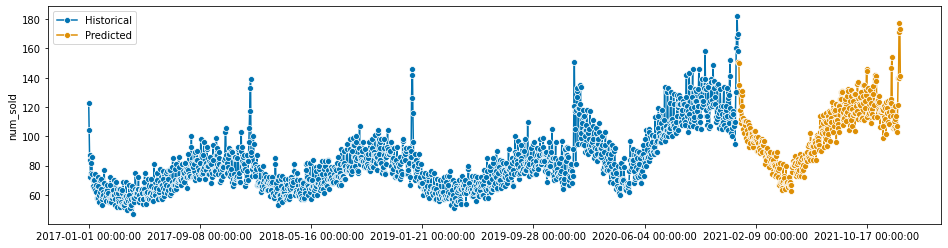

Predicting product ['Spain' 'KaggleRama' 'Kaggle Recipe Book']
0.06413462816249792


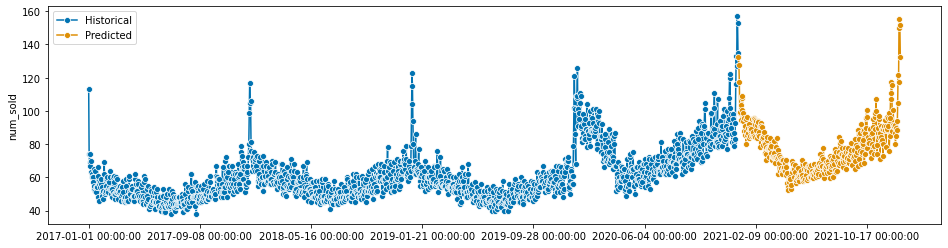

Predicting product ['Spain' 'KaggleRama' 'Kaggle for Kids: One Smart Goose']
0.06436182897670836


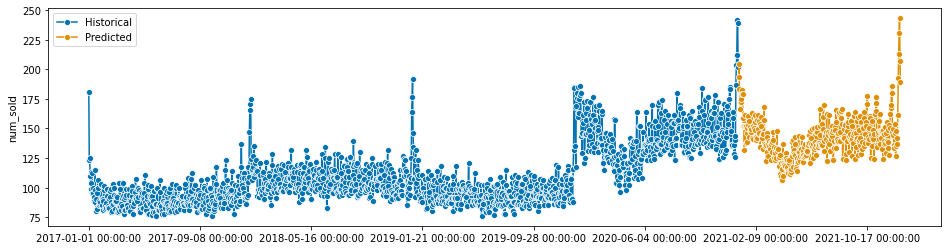

In [16]:
submission_file = pd.DataFrame()
total_score = 0
combinations = train[['country', 'store', 'product']].drop_duplicates(keep='first')

# Get next slice of country store product combinations by date
for i in range(48):
    
    print(f"Predicting product {combinations.iloc[i].values}")
    
# Create series to forecast
    sample_timeseries = train[i::48]
    sample_test = test[i::48]
    y_train = sample_timeseries['num_sold']
    y_train.index = pd.DatetimeIndex(sample_timeseries['date'], freq='D')
    predicted_dates = pd.DatetimeIndex(sample_test['date'], freq='D')

# Create features
    X_train = pd.DataFrame()
    X_train.index = pd.DatetimeIndex(sample_timeseries['date'], freq='D')
    X_test = pd.DataFrame()
    X_test.index = pd.DatetimeIndex(sample_test['date'], freq='D')
    
# Date features
    X_train['dayofweek'] = sample_timeseries['date'].dt.dayofweek.values
    X_test['dayofweek'] = sample_test['date'].dt.dayofweek.values
    
    X_train['dayofmonth'] = sample_timeseries['date'].dt.day.values
    X_test['dayofmonth'] = sample_test['date'].dt.day.values
    
    X_train['dayofyear'] = sample_timeseries['date'].dt.dayofyear.values
    X_test['dayofyear'] = sample_test['date'].dt.dayofyear.values
    
    X_train['month'] = sample_timeseries['date'].dt.month.values
    X_test['month'] = sample_test['date'].dt.month.values
    
    X_train['year'] = sample_timeseries['date'].dt.year.values - sample_timeseries['date'].dt.year.min()
    X_test['year'] = sample_test['date'].dt.year.values - sample_timeseries['date'].dt.year.min()
    
# Fourier Features
    X_train[['Sin', 'Cos']] = cal_fourier_gen.in_sample(X_train.index)
    X_test[['Sin', 'Cos']] = cal_fourier_gen.in_sample(X_test.index)
    
# Pandemic (Did not end in 2020 LOL)
    X_train['Pandemic'] = (y_train.index.year >= 2020).astype(int)
    X_test['Pandemic'] = (X_test.index.year >= 2020).astype(int)
    
    pipe = ForecastingPipeline(steps=[("Scaler", TabularToSeriesAdaptor(StandardScaler())), ("Forecaster", forecaster)])
    
# Forecast product sales for the next year
    pipe.fit(y_train, X_train, fh=fh)
    y_pred = pipe.predict(fh=ForecastingHorizon(predicted_dates, is_relative=False), X=X_test)

# Print SMAPE on last 365 days of training data
    score = pipe.score(y_train[-365:], X_train[-365:])
    print(score)
    total_score += score
    
# Plot projected sales
    plot_series(y_train, y_pred, labels=['Historical', 'Predicted'])
    plt.show()
    
# Append projected sales to new dataframe with index. This will be the submission file.
    with_index = pd.DataFrame(y_pred.values, index=sample_test.index, columns=['num_sold'])
    submission_file = pd.concat([submission_file, with_index], axis=0)


## Submission

In [17]:
# Sort dataframe by index to make sure it matches with submission
print("Unofficial Score", total_score / 48 * 100)
submission_file.sort_index().to_csv('submission.csv')

Unofficial Score 6.931956263744208
